# Tutorial 4: Unstructured Pruning on Bert

Pruning is a technique used to reduce the size and complexity of neural networks by removing unnecessary parameters (weights and connections) or structural components (neurons, filters, or layers). The goal is to create a smaller, more efficient model that maintains most of the original model's performance. The following benefits can be seen from pruning neural networks:

- **Reduce model size**: Deep neural networks often have millions of parameters, leading to large storage requirements.

- **Decrease inference time**: Fewer parameters mean fewer computations, resulting in faster predictions.

- **Improve generalization**: Removing unnecessary connections can help prevent overfitting.

- **Energy efficiency**: Smaller models require less energy to run, which is crucial for edge devices and mobile applications.

Structured pruning removes entire structures (e.g., channels, filters, or layers) from the network, while unstructured pruning removes individual weights or connections from the network, regardless of their location. In this tutorial, we'll build on top of Tutorial 3 by taking the quantized Bert model and running Mase's unstructured pruning pass. After pruning, we'll run further fine tuning iterations to retain sequence classification accuracy in the pruned model.

In [1]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

## Importing the model

If you are starting from scratch, you can create a MaseGraph for Bert by running the following cell.

In [ ]:
from transformers import AutoModelForSequenceClassification

from chop import MaseGraph
import chop.passes as passes

model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
model.config.problem_type = "single_label_classification"

mg = MaseGraph(
    model,
    hf_input_names=[
        "input_ids",
        "attention_mask",
        "labels",
    ],
)

mg, _ = passes.init_metadata_analysis_pass(mg)
mg, _ = passes.add_common_metadata_analysis_pass(mg)

If you have previously ran the tutorial on Quantization-Aware Training (QAT), run the following cell to import the fine tuned checkpoint.

In [5]:
from pathlib import Path
from chop import MaseGraph

mg = MaseGraph.from_checkpoint(f"{Path.home()}/adlsystems/tutorial_3_qat")

/rds/general/user/jj21/home/adlsystems/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)


## Unstructured Pruning

Before running pruning, let's evaluate the model accuracy on the IMDb dataset. If you're coming from Tutorial, this would be the same as the accuracy after Quantization Aware Training (QAT). If you've just initialized the model, this will likely be a random guess (i.e. around 50%), in which case pruning wouldn't have a significant effect on the accuracy.

In [6]:
from chop.tools import get_tokenized_dataset, get_trainer

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)

# Evaluate accuracy
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

baseline_accuracy = eval_results['eval_accuracy']

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
/rds/general/user/jj21/home/adlsystems/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.87252


To run the pruning pass, we pass the following pruning configuration dictionary, which defines the following parameters.

- **Sparsity**: a value between 0 and 1, expressing the proportion of elements in the model that should be pruned (i.e. set to 0).

- **Method**: several pruning methods are supported, including ``Random`` and ``L1-Norm``.

- **Scope**: defines whether to consider each weight/activation tensor individually (``local``) or all tensors in the model (``global``) when obtaining statistics for pruning (e.g. absolute value threshold for pruning)

We'll start by running random pruning with local scope, at a fixed sparsity. This may be suboptimal, but in future tutorials we'll see how to find optimal pruning and quantization configurations for a given model on a specified dataset.

In [5]:
import chop.passes as passes

pruning_config = {
    "weight": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
    "activation": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
}

print("Pruning..")
mg, _ = passes.prune_transform_pass(mg, pass_args=pruning_config)

Pruning..


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Let's evaluate the effect of pruning on accuracy. It's likely to observe drops of around 10% or more.

In [10]:
trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
    num_train_epochs=5,
)

# Evaluate accuracy
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

baseline_accuracy = eval_results['eval_accuracy']

/rds/general/user/jj21/home/adlsystems/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.86848


To overcome the drop in accuracy, we'll run a few finetuning epochs. This allows the model to adapt to the new pruning mask.

In [7]:
trainer.train()

Step,Training Loss
500,0.259600
1000,0.236600
1500,0.248700
2000,0.258400
2500,0.264900
3000,0.296900
3500,0.244800
4000,0.207900
4500,0.189300
5000,0.198700


TrainOutput(global_step=15625, training_loss=0.17638785510253907, metrics={'train_runtime': 290.5811, 'train_samples_per_second': 430.172, 'train_steps_per_second': 53.772, 'total_flos': 0.0, 'train_loss': 0.17638785510253907, 'epoch': 5.0})

Let's evaluate the model accuracy after finetuning. We should see that the accuracy is reverted back to the original level.

In [8]:
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

Evaluation accuracy: 0.86848


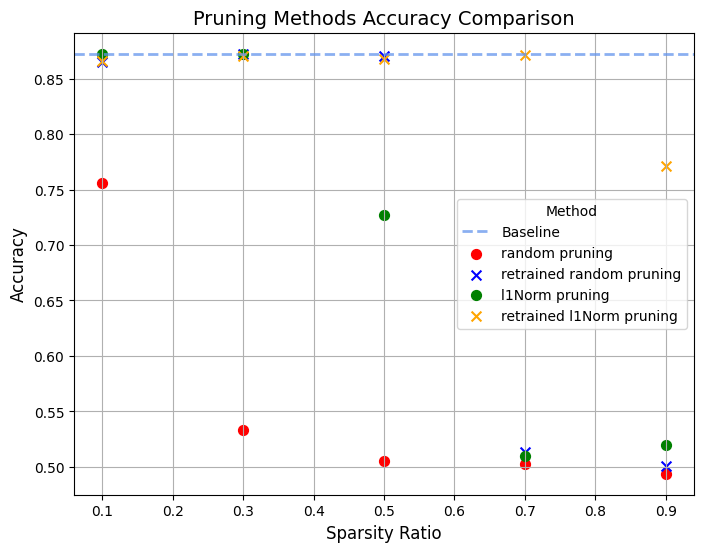

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load DataFrame
df = pd.read_csv("pruning_results.csv")

# Define styles manually
styles = {
    "random pruning": {"color": "red", "marker": "o", "alpha": 1, "linestyle": "dashed"},
    "retrained random pruning": {"color": "blue", "marker": "x", "alpha": 1, "linestyle": "dashed"},
    
    "l1Norm pruning": {"color": "green", "marker": "o", "alpha": 1, "linestyle": "dashed"},
    "retrained l1Norm pruning": {"color": "orange", "marker": "x", "alpha": 1, "linestyle": "dashed"},
}

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.axhline(y=baseline_accuracy, color="cornflowerblue", linestyle="dashed", linewidth=2, label="Baseline", alpha=0.75)

# Manually scatter plot each method and connect points with dashed lines
for method, style in styles.items():
    plt.scatter(df["sparsity"], df[method], 
                color=style["color"], marker=style["marker"], alpha=style["alpha"],
                s=50, label=method)
    
    # Connect points with a dashed line
    # plt.step(df["sparsity"], df[method], 
    #          color=style["color"], linestyle=style["linestyle"], alpha=0.5)

# Customize plot
plt.xlabel("Sparsity Ratio", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Pruning Methods Accuracy Comparison", fontsize=14)
plt.grid(True)
plt.legend(title="Method")
plt.savefig("Pruning.png")